### Get the HMFs for all sims:

In [ ]:
import numpy as np
from gal_goku import hmf as halo_mass_func

for fid in ['HF', 'L2', 'L1']:
    base_dir = f'/scratch/06536/qezlou/Goku/FOF/{fid}'
    save_File = f'/scratch/06536/qezlou/Goku/processed_data/HMF/{fid}_hmfs.hdf5'
    hmf = halo_mass_func.Hmf()
    hmf.get_all_fof_hmfs(base_dir=base_dir, save_file=save_File)
    print(f'fid = {fid} is done!')

## Plot HMFs:

Spline smoothing: use mass bins of 0.1 dex and interpolate with cubic spline to get hmf on 0.05 dex mass bins.

This only marginally helps to suppress the fluctuations in L2 HMF (compare "interpolated" and "fine bin" where the latter is the HMF directly on 0.05 dex, hence a bit noisier)

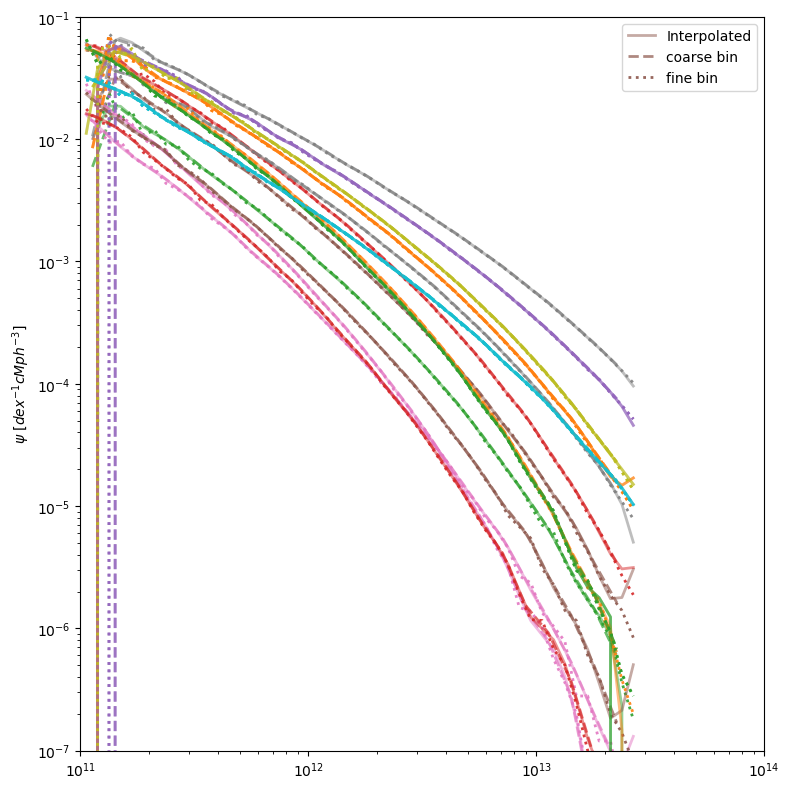

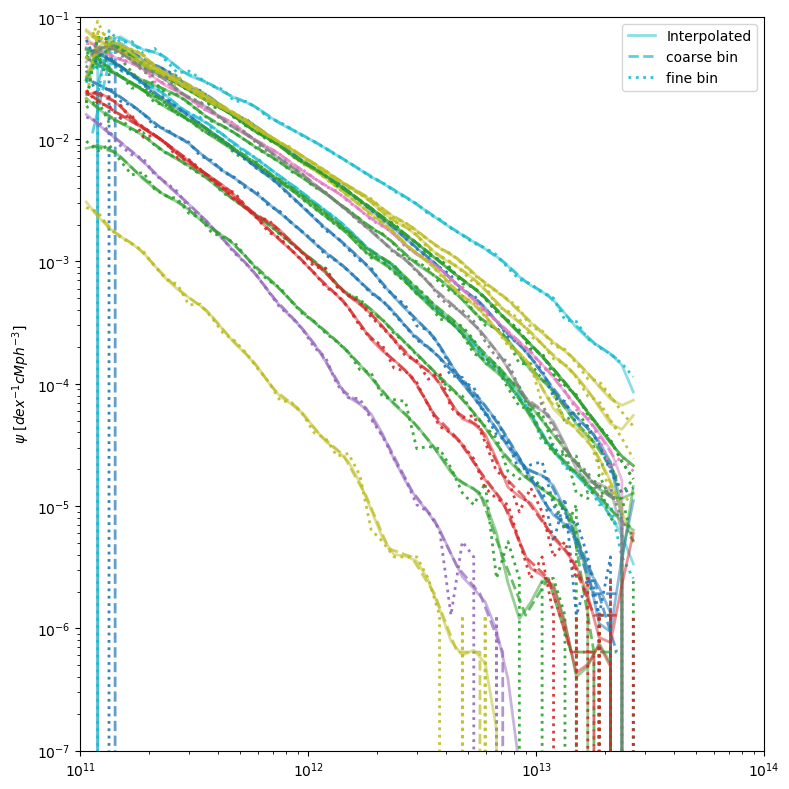

In [3]:
from gal_goku import plot

save_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/HMF'
plt_hmf = plot.PlotHMF(data_dir=save_dir)

plt_hmf.check_smoothed_hmf(fids=['HF','L2'])

## Comapre fidelities:

2025-01-09 17:12:52.995468: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-09 17:12:53.088435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-09 17:12:53.088457: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-01-09 17:12:53.115236: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 17:12:53.560381: W tensorflow/stream_executor/platform/de

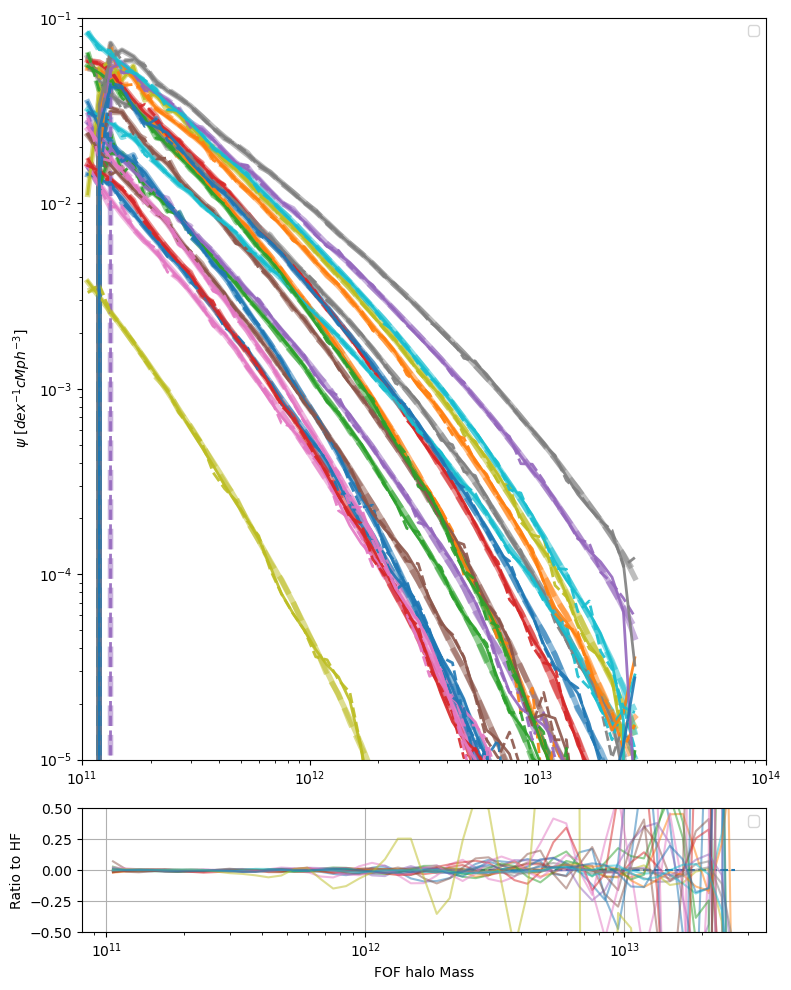

In [1]:
from gal_goku import plot

save_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/HMF'
plt_hmf = plot.PlotHMF(data_dir=save_dir)

plt_hmf.compare_fids(fids=['HF', 'L2'])

# HMF Emu:

## Single fid on L2: